Copyright (c) 2017, Johannes Schöneberg All rights reserved.
The default copyright laws apply.

In [1]:
# by Joh Schöneberg 2018

%matplotlib inline

#pip install lvm_read
import lvm_read
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

import scipy.ndimage




%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

#own modules / functions
import sys
pythonPackagePath = "/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis/"
sys.path.append(pythonPackagePath+"/modules")
import InputProcessing as inproc


In [21]:
path = '/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/'

inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")


inputParameters

,key,value
0,input_data_folder,.
1,output_data_folder,.
2,forceFile_raw_originalFilename,v7_OH_MY_GOOOOODDDD!!!! Movie 001.nd2
3,forceFile_raw_dataShareFilename,forceFile_raw.lvm
4,forceFile,forceFile.csv
5,forceFile_plot,forceFile.png
6,forceFile_alpha_y,-1519
7,forceFile_kappa_y,0.1992
8,UVstart_seconds_fftime,195
9,UVend_seconds_fftime,495


In [3]:
def ma(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]/n

In [4]:
def getLVMdatetime(lvmTimeString,lvmDateString):
    dateString = lvmDateString
    dateSplit=dateString.split('/')
    

    timeString = lvmTimeString
    timeSplit=timeString.split(':')

    #test = datetime.datetime(2017, 6, 26, 18, 21, 16, 533499)
    # this is the time the file was r
    test = datetime.datetime(int(dateSplit[0]), 
                         int(dateSplit[1]), 
                         int(dateSplit[2]), 
                         int(timeSplit[0]), 
                         int(timeSplit[1]), 
                         int(timeSplit[2].split('.')[0]), 
                        0)
    
    #print(test.strftime('%Y-%m-%d %H:%M:%S'))
    return test

In [5]:
def readForceFile(filename):
    lvm = lvm_read.read(infilename, read_from_pickle=False)
    #print(lvm['Description'])
    
    datetime = getLVMdatetime(lvm[0]['Time'][0],lvm[0]['Date'][0])
    
    data = lvm[0]['data']
    t = data[:,0]
    x = data[:,1]
    y = data[:,2]
    xforceraw = data[:,3]
    yforceraw = data[:,4]
    
    return [t,x,y,datetime,xforceraw,yforceraw]

In [6]:
def getTrajectoryIndexOfTimePoint(timepoint,t):
    return np.where(np.round(t)==timepoint)[0][0]


In [7]:
# this function puts zeros in all positions after the scission event
def cleanForceFileAfterBreak(forceTrajectory,t,breakTime):
    newTrace = []
    idx = getTrajectoryIndexOfTimePoint(breakTime,t)
    for i in range(0,len(forceTrajectory)):
        if(i>=idx):
            newTrace.append(0)
        else:
            newTrace.append(forceTrajectory[i])
    return np.array(newTrace)

/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/forceFile_raw.lvm


Text(0,0.5,'force [AU]')

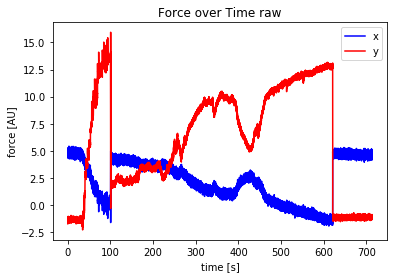

In [8]:
forceFile_raw_dataShareFilename = inproc.getInputParameter(inputParameters,"forceFile_raw_dataShareFilename")
infilename = path+forceFile_raw_dataShareFilename
print(infilename)
t,x,y,forceFileTimeCreated,xforceraw,yforceraw = readForceFile(infilename)


plt.plot(t,scipy.ndimage.median_filter(x,50),c="b",label='x')
plt.plot(t,scipy.ndimage.median_filter(y,50),c="r",label='y')
plt.legend()
plt.title("Force over Time raw")
plt.xlabel("time [s]")
plt.ylabel("force [AU]")

# Laser and other Parameters

In [9]:
 lvm = lvm_read.read(infilename, read_from_pickle=False)
#print(lvm['Description'])

#datetime = getLVMdatetime(lvm[0]['Time'][0],lvm[0]['Date'][0])

data = lvm[0]['data']
t = data[:,0]
xForce = data[:,1]
yForce = data[:,2]
xForceRaw = data[:,3]
yForceRaw = data[:,4]
a_voltage = data[:,5]
b_voltage = data[:,6]
c_voltage = data[:,7]
d_voltage = data[:,8]

Text(0,0.5,'Voltage [AU]')

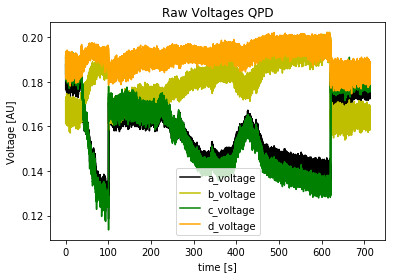

In [10]:

plt.plot(t,scipy.ndimage.median_filter(a_voltage,50),c="k",label='a_voltage')
plt.plot(t,scipy.ndimage.median_filter(b_voltage,50),c="y",label='b_voltage')
plt.plot(t,scipy.ndimage.median_filter(c_voltage,50),c="g",label='c_voltage')
plt.plot(t,scipy.ndimage.median_filter(d_voltage,50),c="orange",label='d_voltage')
plt.legend()
plt.title("Raw Voltages QPD")
plt.xlabel("time [s]")
plt.ylabel("Voltage [AU]")

# force file processing

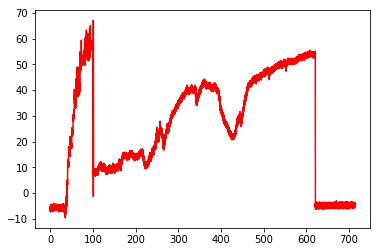

In [11]:
forceFile_alpha_y = float(inproc.getInputParameter(inputParameters,"forceFile_alpha_y"))
forceFile_kappa_y = float(inproc.getInputParameter(inputParameters,"forceFile_kappa_y"))

plt.plot(t,scipy.ndimage.median_filter(forceFile_alpha_y*forceFile_kappa_y*yForceRaw,50),c="r")

In [12]:
#forceScale = 4

forceScale = forceFile_alpha_y*forceFile_kappa_y

UVstart_seconds_fftime = float(inproc.getInputParameter(inputParameters,"UVstart_seconds_fftime"))
tube_break_seconds_fftime = float(inproc.getInputParameter(inputParameters,"tube_break_seconds_fftime"))


time_UV = UVstart_seconds_fftime #seconds after the force file was created
breakTime = tube_break_seconds_fftime #second that the tube breaks
xlimit = (-1.3*time_UV,1.3*(breakTime-time_UV))

#this sets the section of the force file that is relevant for future analysis, 
# i.e. from tube pulling to just after break
zoomTime0 = 0
zoomTime1 = 700

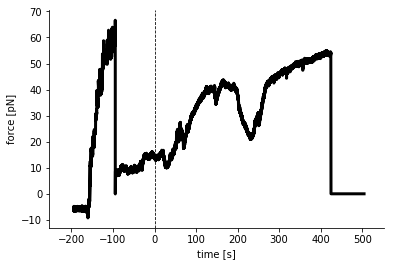

In [13]:
# rescaling approx..

idx0 = getTrajectoryIndexOfTimePoint(zoomTime0,t)
idx1 = getTrajectoryIndexOfTimePoint(zoomTime1,t)



cleanedTrace = scipy.ndimage.median_filter(cleanForceFileAfterBreak(yForceRaw,t,breakTime)[idx0:idx1],100)

plt.plot(t[idx0:idx1]-time_UV,forceScale*cleanedTrace,c='k',lw=3)
plt.xlabel("time [s]")
plt.ylabel("force [pN]")
plt.axvline(0, color='k', linestyle='--', lw=0.8)
plt.xlim(xlimit[0],xlimit[1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

# if necessary: fit the baseline and adjust the rest accordingly

In [14]:
def plotTraceTime(t,y,idx0=-1,idx1=-1):
    cleanedTrace = scipy.ndimage.median_filter(cleanForceFileAfterBreak(y,t,breakTime)[idx0:idx1],100)

    plt.plot(t[idx0:idx1],forceScale*cleanedTrace,c='k',lw=3)
    plt.xlabel("time [s]")
    plt.ylabel("force [pN]")

#    plt.xlim(time[idxfrom-1000],time[idxto+1000])
    plt.show()

185347 232615


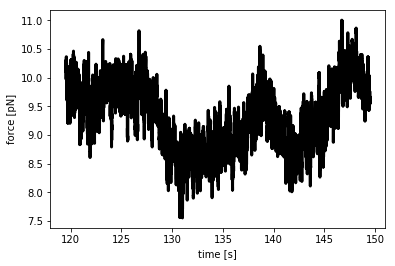

In [15]:
#manually adjust this value
#fit is done from $fitStart to $UV_startTime
# adjust $fitStart according to experimental condition

fitStart = 120 #seconds
fitEnd = 150#UV_startTime

UV_startTime = time_UV

baseline_idx0 = getTrajectoryIndexOfTimePoint(fitStart,t)
baseline_idx1 = getTrajectoryIndexOfTimePoint(fitEnd,t)
print(baseline_idx0,baseline_idx1)
plotTraceTime(t,yForceRaw,baseline_idx0,baseline_idx1)



In [16]:
# fit the baseline
# http://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
def fitBaselineLinear(t,y,idx0,idx1):

    time = t
    force = y
    
    
    x = time[idx0:idx1]
    y = force[idx0:idx1]
    
    fit_baseline = np.polyfit(x,y,1)
    fit_fn_baseline = np.poly1d(fit_baseline) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    

    
    def fn(x):
        return np.multiply(fit_fn_baseline[0],x)+fit_fn_baseline[1]
    
    #plt.plot(x,y, '-', x, fit_fn_baseline(x), '--k')
    #plt.show()
    return(fit_baseline)



#plotTraceTime(fileData,idx0,idx1)

Text(0,0.5,'force[pN]')

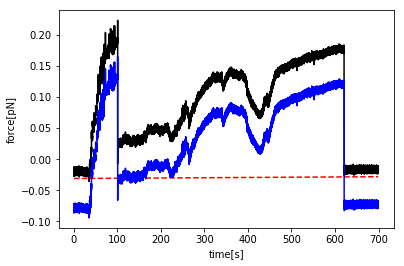

In [17]:

baselineFit = fitBaselineLinear(t,yForceRaw,baseline_idx0,baseline_idx1)

time = t
force = yForceRaw

whole_idx0 = idx0
whole_idx1 = idx1

xx = time[whole_idx0:whole_idx1]
yy = force[whole_idx0:whole_idx1]

fit_fn_baseline = np.poly1d(baselineFit) 
# fit_fn is now a function which takes in x and returns an estimate for y

ws = 20
plt.plot(scipy.ndimage.median_filter(xx,ws),-1*scipy.ndimage.median_filter(yy,ws), '-k', xx, fit_fn_baseline(xx), '--r')
delta= yy[0]-fit_fn_baseline(xx[0])
delta = 0


plt.plot(scipy.ndimage.median_filter(xx,ws),-1*scipy.ndimage.median_filter(yy[0]+yy-fit_fn_baseline(xx)-delta,ws), '-b')
plt.xlabel("time[s]")
plt.ylabel("force[pN]")




/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/./forceFile.png


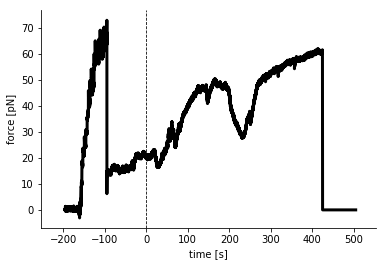

f0_baselineForce: 15.5pN
fmax_maxForce: 61.89pN
∆F: 46.39pN


In [27]:
# rescaling approx..

idx0 = getTrajectoryIndexOfTimePoint(zoomTime0,t)
idx1 = getTrajectoryIndexOfTimePoint(zoomTime1,t)





time = t[idx0:idx1]
trace = cleanForceFileAfterBreak(y,t,breakTime)[idx0:idx1]
fittedTrace = fit_fn_baseline(t[idx0:idx1])

trace_correctedFor_drift = yForceRaw-fit_fn_baseline(t)
trace_correctedFor_drift_yZero = trace_correctedFor_drift-np.average(trace_correctedFor_drift[0:1000])
correctedTrace = forceScale*trace_correctedFor_drift_yZero
timeSlice = t[idx0:idx1]
traceSlice = cleanForceFileAfterBreak(correctedTrace,t,breakTime)[idx0:idx1]

#fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(timeSlice-time_UV,scipy.ndimage.median_filter(traceSlice,100),c='k',lw=3)
plt.xlabel("time [s]")
plt.ylabel("force [pN]")
plt.axvline(0, color='k', linestyle='--', lw=0.8)
plt.xlim(xlimit[0],xlimit[1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")
forceFile_plot = inproc.getInputParameter(inputParameters,"forceFile_plot")
outputPath = path+outputDataFolder+'/'+forceFile_plot
print()
print(outputPath)
plt.savefig(outputPath)
plt.show()



baselineForce = np.average(correctedTrace[baseline_idx0:baseline_idx1])
traceSliceUvToEnd = traceSlice[getTrajectoryIndexOfTimePoint(time_UV,timeSlice):-1]
maxForce = np.max(scipy.ndimage.median_filter(traceSliceUvToEnd,100))
print("f0_baselineForce: {}pN".format(np.round(baselineForce,2)))
print("fmax_maxForce: {}pN".format(np.round(maxForce,2)))
print("∆F: {}pN".format(np.round(maxForce-baselineForce,2)))



In [19]:
## OUTPUT
outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")
forceFile_name = inproc.getInputParameter(inputParameters,"forceFile")
outputPath = path+outputDataFolder+'/'+forceFile_name
print(outputPath)

#only write every 10th datapoint (otherwise you end up with 10s of megabytes of force data)
out_time = (timeSlice-time_UV)[::10]
out_force = scipy.ndimage.median_filter(traceSlice,100)[::10]
output_data = np.transpose(np.asarray((out_time,out_force)))


with open(outputPath,'wb') as outfile:
    np.savetxt(outfile, 
           output_data, 
           delimiter=',',
           fmt='%10.5f',
           header="time[s], force[pN]"
              ) 

/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/./forceFile.csv
